# Ausgangssituation:
Ich habe von meiner wohlhabenden Tante aus den USA ein paar Millionen Euro zum Geburtstag bekommen.
Um das Beste daraus zu machen würde ich gerne zusammen mit zwei Freunden mit dem Geld auf dem Immobilienmarkt spekulieren, aber wann wäre es der richtige Zeitpunkt in diesen unvorhersehbaren Markt einzusteigen. Ich kenne mich mit der Marktentwicklung nicht so gut aus. Es gibt sicher sehr viele Faktoren, die die Preisentwicklung in der Immobilien in den USA beeinflussen. Also setze ich mit mit den klügsten Menschen zusammen und versuchen Analytisch und historisch vorzugehen. Wir werden anhand unterschiedlichen Faktoren und unterschiedlichen historischen Daten(in den letzten 5 Jahren) den richtigen Zeitpunkt in den nächsten 12 Monaten herausfinden in dem es am Besten ist Immobilien zu kaufen. *Ziel* ist es Immobilien zu kaufen wenn die Preise niedrig sind und sie Verkaufen wenn sie steigen. 

- Für die Prognose entscheiden wir uns nach Überelgungen und Vorschlägen von Datenspezialisten für *Random Forest*.

- Die Wirtschaftlichen Faktoren, die berücksichtigt werden sind die *Unemployment Rate, Consumer Price Index for All Urban Consumers, Effective Federal Funds Rate, Gross Domestic Product*. Die daten sammeln wir mittels *Fred API* https://fred.stlouisfed.org/

- Die historischen Daten für die Immobilienpreise haben wir von https://www.zillow.com/research/data als *.csv-Datei.

- Dazu werden wir mittels *Webscraping* den Kurs von den *S&P500*(ein Aktienindex, der die Aktien von 500 der größten börsennotierten US-amerikanischen Unternehmen umfasst. Der S&P 500 ist nach der Marktkapitalisierung gewichtet), *klingt als würde es ein Einfluss auf die Immobilienpreise haben. 


# fetch data from FRED API

In [2]:
import requests
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# FRED API key
api_key = "c01238061836b8987695bc04805676bc"

# List of relevant economic indicators
economic_indicators = {
    "UNRATE": "Unemployment Rate",
    "CPIAUCSL": "Consumer Price Index for All Urban Consumers",
    "FEDFUNDS": "Effective Federal Funds Rate",
    "GDP": "Gross Domestic Product"
}
start_date = "2019-06-01"
end_date = "2024-06-01"

In [123]:
def fetch_fred_data(series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data['observations'])
    df['value'] = df['value'].astype(float)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df[['value']]

economic_data = pd.DataFrame()
for indicator, name in economic_indicators.items():
    data = fetch_fred_data(indicator, start_date, end_date)
    data.columns = [name]
    if economic_data.empty:
        economic_data = data
    else:
        economic_data = economic_data.join(data, how='outer')
        
# Füge die Datumsspalte hinzu
economic_data.reset_index(inplace=True)
economic_data.rename(columns={'index': 'date'}, inplace=True)

print(economic_data)

         date  Unemployment Rate  \
0  2019-04-01                NaN   
1  2019-06-01                3.6   
2  2019-07-01                3.7   
3  2019-08-01                3.6   
4  2019-09-01                3.5   
..        ...                ...   
56 2024-01-01                3.7   
57 2024-02-01                3.9   
58 2024-03-01                3.8   
59 2024-04-01                3.9   
60 2024-05-01                4.0   

    Consumer Price Index for All Urban Consumers  \
0                                            NaN   
1                                        255.213   
2                                        255.802   
3                                        256.036   
4                                        256.430   
..                                           ...   
56                                       309.685   
57                                       311.054   
58                                       312.230   
59                                       313.20

- Ersetzen von NaN durch den letzten gültigen Wert in jeder Spalte.

Fillforward the NaN values

In [124]:
economic_data.fillna(method='ffill', inplace=True)
print(economic_data)

         date  Unemployment Rate  \
0  2019-04-01                NaN   
1  2019-06-01                3.6   
2  2019-07-01                3.7   
3  2019-08-01                3.6   
4  2019-09-01                3.5   
..        ...                ...   
56 2024-01-01                3.7   
57 2024-02-01                3.9   
58 2024-03-01                3.8   
59 2024-04-01                3.9   
60 2024-05-01                4.0   

    Consumer Price Index for All Urban Consumers  \
0                                            NaN   
1                                        255.213   
2                                        255.802   
3                                        256.036   
4                                        256.430   
..                                           ...   
56                                       309.685   
57                                       311.054   
58                                       312.230   
59                                       313.20

In [ ]:
- Erste Zeile löschen

In [125]:
economic_data = economic_data.drop(economic_data.index[0])
economic_data.head()

,date,Unemployment Rate,Consumer Price Index for All Urban Consumers,Effective Federal Funds Rate,Gross Domestic Product
1,2019-06-01,3.6,255.213,2.38,21384.775
2,2019-07-01,3.7,255.802,2.40,21694.282
3,2019-08-01,3.6,256.036,2.13,21694.282
4,2019-09-01,3.5,256.430,2.04,21694.282
5,2019-10-01,3.6,257.155,1.83,21902.390


In [126]:
# gibt's noch Nullwerte?
nan_counts = economic_data.isnull().sum()
print(nan_counts)

date                                            0
Unemployment Rate                               0
Consumer Price Index for All Urban Consumers    0
Effective Federal Funds Rate                    0
Gross Domestic Product                          0
dtype: int64


Wir werden folgende Änderungen vornehmen:

- Änderung des Datumsformats in das gewünschte Monat-Jahr-Format.

In [127]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format

In [128]:
spark = SparkSession.builder.appName("EconomicData").getOrCreate()
economic_data_spark = spark.createDataFrame(economic_data)


economic_data_spark = economic_data_spark.withColumn(
    "date", date_format(col("date"), "MM-yyyy")
)


economic_data_spark.show()

economic_data=economic_data_spark.toPandas()

spark.stop()

+-------+-----------------+--------------------------------------------+----------------------------+----------------------+
|   date|Unemployment Rate|Consumer Price Index for All Urban Consumers|Effective Federal Funds Rate|Gross Domestic Product|
+-------+-----------------+--------------------------------------------+----------------------------+----------------------+
|06-2019|              3.6|                                     255.213|                        2.38|             21384.775|
|07-2019|              3.7|                                     255.802|                         2.4|             21694.282|
|08-2019|              3.6|                                     256.036|                        2.13|             21694.282|
|09-2019|              3.5|                                      256.43|                        2.04|             21694.282|
|10-2019|              3.6|                                     257.155|                        1.83|              21902.39|


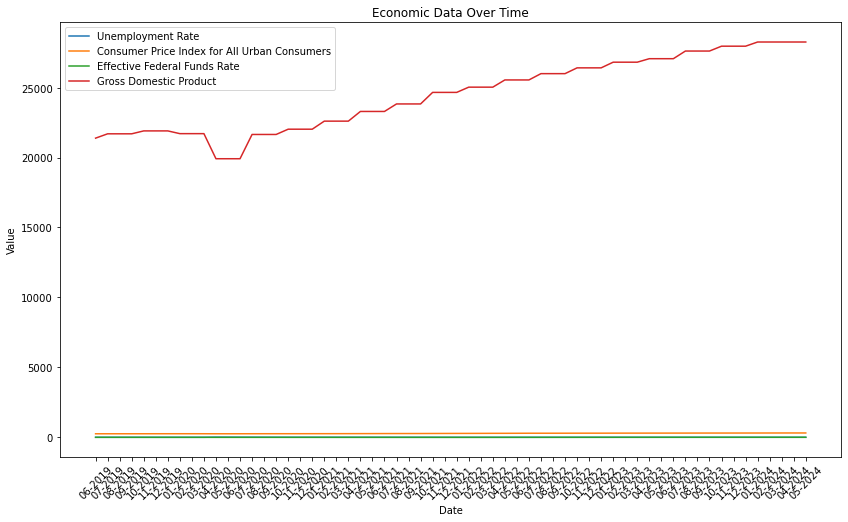

In [129]:
import matplotlib.pyplot as plt
import pandas as pd


economic_data.set_index('date', inplace=True)


plt.figure(figsize=(14, 8))

for column in economic_data.columns:
    plt.plot(economic_data.index, economic_data[column], label=column)


plt.title('Economic Data Over Time')
plt.xlabel('Date')
plt.ylabel('Value')


plt.legend()


plt.xticks(rotation=45)


plt.show()

Die Daten werden standardisiert, damit sie auf der gleichen Skala dargestellt werden. 

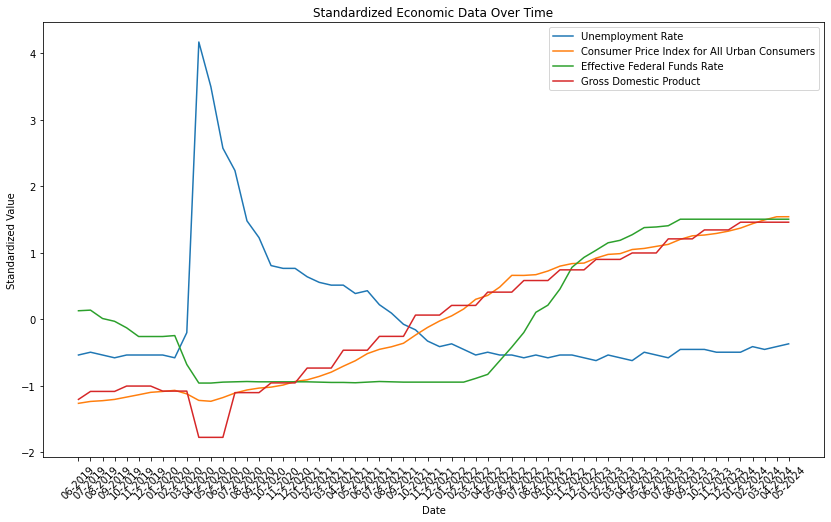

In [130]:

standardized_data = (economic_data - economic_data.mean()) / economic_data.std()



plt.figure(figsize=(14, 8))

for column in standardized_data.columns:
    plt.plot(standardized_data.index, standardized_data[column], label=column)


plt.title('Standardized Economic Data Over Time')
plt.xlabel('Date')
plt.ylabel('Standardized Value')


plt.legend()


plt.xticks(rotation=45)

plt.show()

Jetzt werden die Daten aus der .csv-Datei importiert 
das sind die historischen Daten zu Immobilienpreisen nach Region und Monat.

In [38]:
spark = SparkSession.builder \
    .appName("GroupByRegionNameAndMonth") \
    .getOrCreate()

In [39]:
df = spark.read.csv("Metro_zori.csv", header=True, inferSchema=True)
df.show()

+--------+--------+-----------------+----------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------

Schauen wir uns erstmal die Struktur des Datensatzes an:

In [42]:
columns = df.columns
print(columns)

['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-3

In [66]:
state_column = "StateName"
non_month_columns = ["RegionID", "SizeRank", "RegionType", "RegionName"]
month_columns = [col for col in columns if col not in non_month_columns + [state_column]]

escaped_month_columns = [f"`{col}`" for col in month_columns]

stack_expr = f"stack({len(escaped_month_columns)}, " + ", ".join([f"'{col}', {col}" for col in escaped_month_columns]) + ") as (Month, Value)"

df_long = df.selectExpr(state_column, *escaped_month_columns) \
            .selectExpr(state_column, stack_expr)

df_long = df_long.withColumn("Value", df_long["Value"].cast("double"))

avg_df = df_long.groupBy("StateName", "Month").agg(avg("Value").alias("Average_Value"))

pivot_df = avg_df.groupBy("StateName").pivot("Month").avg("Average_Value")

pivot_df = pivot_df.orderBy("StateName")

output_path = "Pivoted_By_StateName_And_Month2.csv"
pivot_df.write.csv(output_path, header=True)


Die Ergebnisse wurden übersichtshalber in eine neue CSV-Datei exportiert 

In [67]:
print(pivot_df.columns)

['StateName', '`2015-01-31`', '`2015-02-28`', '`2015-03-31`', '`2015-04-30`', '`2015-05-31`', '`2015-06-30`', '`2015-07-31`', '`2015-08-31`', '`2015-09-30`', '`2015-10-31`', '`2015-11-30`', '`2015-12-31`', '`2016-01-31`', '`2016-02-29`', '`2016-03-31`', '`2016-04-30`', '`2016-05-31`', '`2016-06-30`', '`2016-07-31`', '`2016-08-31`', '`2016-09-30`', '`2016-10-31`', '`2016-11-30`', '`2016-12-31`', '`2017-01-31`', '`2017-02-28`', '`2017-03-31`', '`2017-04-30`', '`2017-05-31`', '`2017-06-30`', '`2017-07-31`', '`2017-08-31`', '`2017-09-30`', '`2017-10-31`', '`2017-11-30`', '`2017-12-31`', '`2018-01-31`', '`2018-02-28`', '`2018-03-31`', '`2018-04-30`', '`2018-05-31`', '`2018-06-30`', '`2018-07-31`', '`2018-08-31`', '`2018-09-30`', '`2018-10-31`', '`2018-11-30`', '`2018-12-31`', '`2019-01-31`', '`2019-02-28`', '`2019-03-31`', '`2019-04-30`', '`2019-05-31`', '`2019-06-30`', '`2019-07-31`', '`2019-08-31`', '`2019-09-30`', '`2019-10-31`', '`2019-11-30`', '`2019-12-31`', '`2020-01-31`', '`2020-02-

Die Daten vor Juni 2019 sind für unsere Beobachtung nicht relevant. Darum löschen wir sie einfach.

In [81]:
from pyspark.sql.functions import col

cutoff_date = '2019-06-01'


columns_to_keep = [col for col in pivot_df.columns if col == 'StateName' or (col.startswith('`') and col[1:11] >= cutoff_date)]


filtered_df = df.select([col(c).alias(c.strip('`')) for c in columns_to_keep])


filtered_df.show()

output_path = "filtered.csv"
filtered_df.write.csv(output_path, header=True)

+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/stefan/Desktop/Big Data Engineering /filtered.csv already exists. Set mode as "overwrite" to overwrite the existing path.

In [76]:
filtered_df.columns

['StateName',
 '2019-06-30',
 '2019-07-31',
 '2019-08-31',
 '2019-09-30',
 '2019-10-31',
 '2019-11-30',
 '2019-12-31',
 '2020-01-31',
 '2020-02-29',
 '2020-03-31',
 '2020-04-30',
 '2020-05-31',
 '2020-06-30',
 '2020-07-31',
 '2020-08-31',
 '2020-09-30',
 '2020-10-31',
 '2020-11-30',
 '2020-12-31',
 '2021-01-31',
 '2021-02-28',
 '2021-03-31',
 '2021-04-30',
 '2021-05-31',
 '2021-06-30',
 '2021-07-31',
 '2021-08-31',
 '2021-09-30',
 '2021-10-31',
 '2021-11-30',
 '2021-12-31',
 '2022-01-31',
 '2022-02-28',
 '2022-03-31',
 '2022-04-30',
 '2022-05-31',
 '2022-06-30',
 '2022-07-31',
 '2022-08-31',
 '2022-09-30',
 '2022-10-31',
 '2022-11-30',
 '2022-12-31',
 '2023-01-31',
 '2023-02-28',
 '2023-03-31',
 '2023-04-30',
 '2023-05-31',
 '2023-06-30',
 '2023-07-31',
 '2023-08-31',
 '2023-09-30',
 '2023-10-31',
 '2023-11-30',
 '2023-12-31',
 '2024-01-31',
 '2024-02-29',
 '2024-03-31',
 '2024-04-30',
 '2024-05-31']

Zusätzlich ändern wir das Datumsformat auf *MM-YYYY* 

In [82]:
def transform_column_name(name):
    if name == 'StateName':
        return name
    else:
        return f'{name[5:7]}-{name[:4]}'

# Rename columns
for column in filtered_df.columns:
    filtered_df = filtered_df.withColumnRenamed(column, transform_column_name(column))

# Show the filtered DataFrame with renamed columns
filtered_df.show()
filtered_df.write.csv("output", header=True)

+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/stefan/Desktop/Big Data Engineering /output already exists. Set mode as "overwrite" to overwrite the existing path.

Die Daten werden noch schnell nach Staat grouppiert

In [92]:
from pyspark.sql.types import NumericType

numeric_cols = [field.name for field in filtered_df.schema.fields if isinstance(field.dataType, NumericType)]


avg_df = filtered_df.groupBy("StateName").agg(
    *[avg(col).alias(col) for col in numeric_cols]
)

final_df = avg_df.join(filtered_df.select("StateName").distinct(), on="StateName", how="left")


final_df.show()



final_df.coalesce(1).write.csv("output3", header=True)


+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-

## Visualisierungen

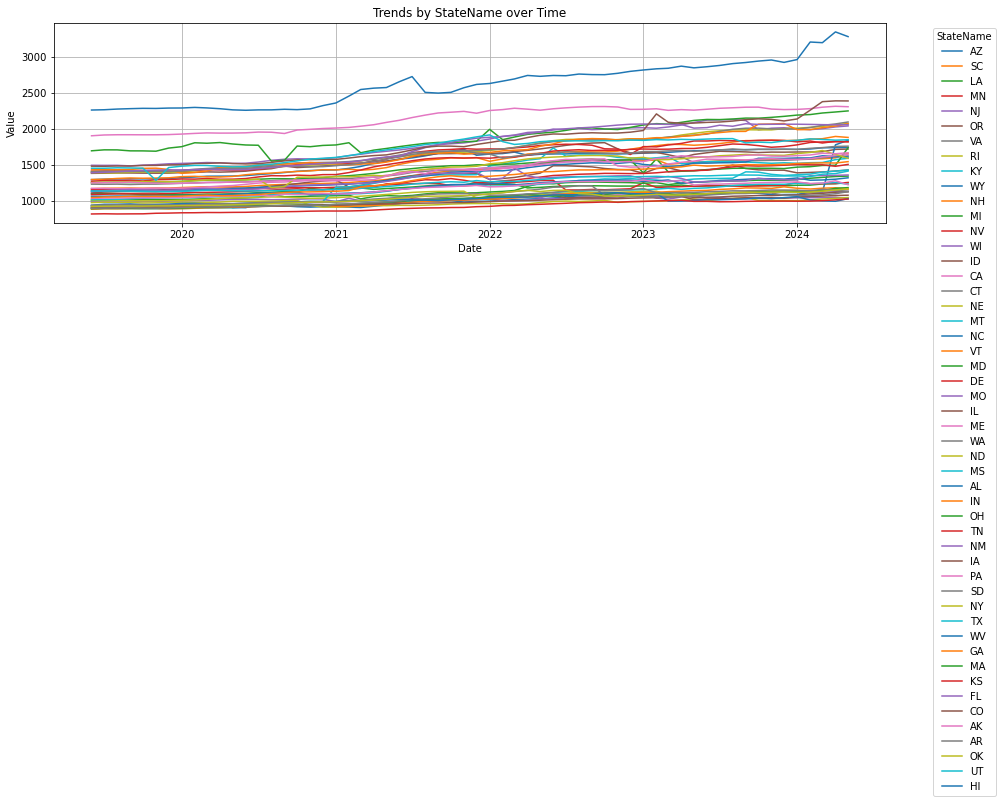

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a pandas DataFrame
final_df_pandas = final_df.toPandas()

# Melt the dataframe to a long format for plotting
data_long = pd.melt(final_df_pandas, id_vars=['StateName'], var_name='Date', value_name='Value')

# Convert the 'Date' column to datetime format
data_long['Date'] = pd.to_datetime(data_long['Date'], format='%m-%Y', errors='coerce')

# Plot the data
plt.figure(figsize=(14, 8))
for state in data_long['StateName'].unique():
    state_data = data_long[data_long['StateName'] == state]
    plt.plot(state_data['Date'], state_data['Value'], label=state)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trends by StateName over Time')
plt.legend(title='StateName', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Save and show the plot
plt.savefig('plot2.png')
plt.show()


In [102]:
import numpy as np
from scipy.stats import linregress

descriptive_stats = final_df_pandas.describe().transpose()

descriptive_stats

def calculate_trend_slope(series):
    x = np.arange(len(series))
    slope, intercept, r_value, p_value, std_err = linregress(x, series)
    return slope

data_long = pd.melt(final_df_pandas, id_vars=['StateName'], var_name='Date', value_name='Value')
data_long['Date'] = pd.to_datetime(data_long['Date'], format='%m-%Y', errors='coerce')


trend_slopes = data_long.groupby('StateName')['Value'].apply(calculate_trend_slope).reset_index()
trend_slopes.columns = ['StateName', 'TrendSlope']

trend_slopes


,StateName,TrendSlope
0,AK,8.528663
1,AL,5.027926
2,AR,4.333099
3,AZ,8.557690
4,CA,8.332475
5,CO,15.257462
6,CT,12.341927
7,DE,10.802517
8,FL,14.795354
9,GA,9.880690


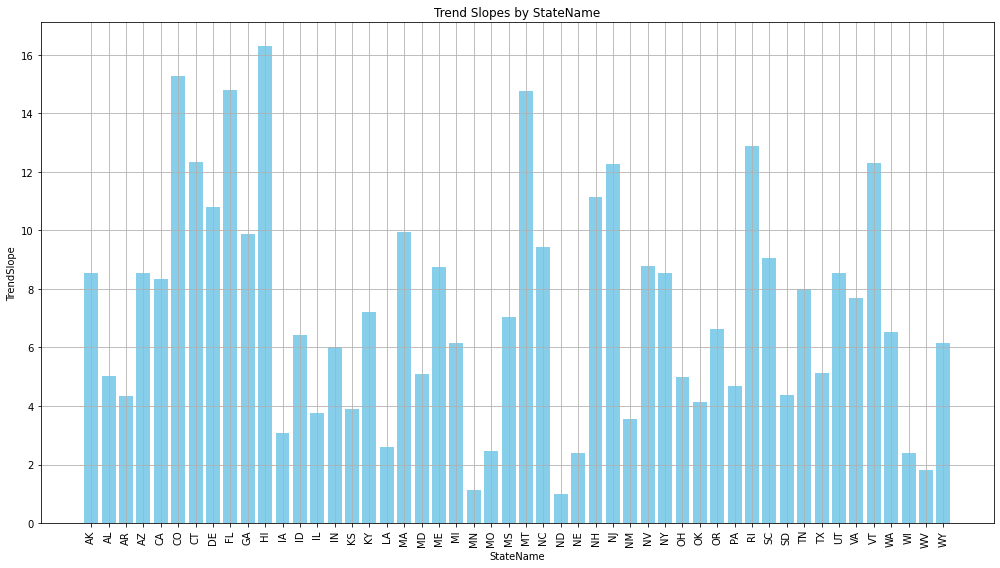

In [103]:
import matplotlib.pyplot as plt

# Plot the trend slopes
plt.figure(figsize=(14, 8))
plt.bar(trend_slopes['StateName'], trend_slopes['TrendSlope'], color='skyblue')
plt.xlabel('StateName')
plt.ylabel('TrendSlope')
plt.title('Trend Slopes by StateName')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()

Jetzt werden wir mal die Datensätze zusammenlegen. Erstmal das Datum als index verwenden. Das schaffen wir indem wir unsere Dataframe transponieren.

In [106]:

data = final_df_pandas


data.set_index('StateName', inplace=True)


transposed_data = data.T


transposed_data.index = pd.to_datetime(transposed_data.index, format='%m-%Y')






KeyError: "None of ['StateName'] are in the columns"

In [113]:
transposed_data.index = transposed_data.index.strftime('%m-%Y')
print(transposed_data.head())

StateName           AZ           SC           LA           MN           NJ  \
06-2019    1291.909445  1165.824095  1095.214347  1152.340555  1491.760513   
07-2019    1298.162411  1171.498062  1099.163564  1150.882809  1490.548749   
08-2019    1301.787596  1173.205740  1096.604475  1152.102428  1490.888178   
09-2019    1304.149811  1174.814329  1091.832988  1145.665775  1483.336575   
10-2019    1301.782265  1172.348739  1085.212836  1147.051347  1494.422655   

StateName           OR          NaN           VA           RI          KY  \
06-2019    1379.415663  1518.663986  1228.617661  1390.198264  884.594556   
07-2019    1381.368594  1524.928722  1227.047451  1387.848733  889.700042   
08-2019    1384.873697  1528.358142  1228.940698  1385.470565  892.201663   
09-2019    1384.456858  1528.513783  1224.098518  1392.427716  889.856055   
10-2019    1382.438408  1527.246724  1228.513836  1397.182532  886.938524   

StateName  ...           GA           MA          KS           FL  \

In [134]:
df = transposed_data.join(standardized_data, how='inner')

In [135]:
df.to_csv('housing_economica.csv')

Jetzt wurden die Immobilienpreise mit den wirtschaftlichen Indexen zusammengelegt und in einer CSV_Datei gespeichert.

In [132]:
print(df.head())
print(economic_data.head())
print(transposed_data.head())

                  AZ           SC           LA           MN           NJ  \
06-2019  1291.909445  1165.824095  1095.214347  1152.340555  1491.760513   
07-2019  1298.162411  1171.498062  1099.163564  1150.882809  1490.548749   
08-2019  1301.787596  1173.205740  1096.604475  1152.102428  1490.888178   
09-2019  1304.149811  1174.814329  1091.832988  1145.665775  1483.336575   
10-2019  1301.782265  1172.348739  1085.212836  1147.051347  1494.422655   

                  OR          NaN           VA           RI          KY  ...  \
06-2019  1379.415663  1518.663986  1228.617661  1390.198264  884.594556  ...   
07-2019  1381.368594  1524.928722  1227.047451  1387.848733  889.700042  ...   
08-2019  1384.873697  1528.358142  1228.940698  1385.470565  892.201663  ...   
09-2019  1384.456858  1528.513783  1224.098518  1392.427716  889.856055  ...   
10-2019  1382.438408  1527.246724  1228.513836  1397.182532  886.938524  ...   

                  CO           AK          AR          OK     